Small experiments for rendering transformed images without aliasing artifacts.  We use integral images to approximate an appropriately scaled kernel for each target pixel with a box filter of the size of one scaled pixel.

First include ImageJ and the mpicbg library that includes a useful integral image implementationa and transformation models:

In [1]:
%mavenRepo scijava.public https://maven.scijava.org/content/groups/public
%maven net.imagej:ij:1.53s
%maven mpicbg:mpicbg_:1.4.0
%maven sc.fiji:panorama_:3.0.2

import ij.*;
import ij.process.*;
import java.util.*;
import mpicbg.ij.*;
import mpicbg.ij.integral.*;
import mpicbg.models.*;
import mpicbg.panorama.*;

This is the `TransformMapping` class from `mpicbg` but with a member source, so we can make and re-use an integral image for all subsequent mappings:

In [2]:
public class PrettyMapping<T extends CoordinateTransform> {

    final protected IntegralImage integral;
    final protected ImageProcessor source;
    final protected T transform;
    final public T getTransform(){ return transform; }
    
    private static final IntegralImage integrate(final ImageProcessor ip) {
        
        if (FloatProcessor.class.isInstance(ip))
            return new DoubleIntegralImage((FloatProcessor)ip);
        else if (ByteProcessor.class.isInstance(ip))
            return new LongIntegralImage((ByteProcessor)ip);
        else if (ShortProcessor.class.isInstance(ip))
            return new LongIntegralImage((ShortProcessor)ip);
        else if (ColorProcessor.class.isInstance(ip))
            return new LongRGBIntegralImage((ColorProcessor)ip);
        else
            return null;
    }

    private static final double squareLength(
            final double x0,
            final double y0,
            final double x1,
            final double y1) {
        
        final double dx = x1 - x0;
        final double dy = y1 - y0;
        
        return dx * dx + dy * dy;
    }
    
    private static final double length(
            final double x0,
            final double y0,
            final double x1,
            final double y1) {
        
        return Math.sqrt(squareLength(x0, y0, x1, y1));
    }

    public PrettyMapping(
            final ImageProcessor source,
            final T transform) {
        
        this.source = source;
        this.transform = transform;
        this.integral = integrate(source);
    }
    
    public void map(final ImageProcessor target) {
        
        source.setInterpolationMethod(ImageProcessor.BICUBIC);
    
        final double[] t = new double[3];
        final int sw = source.getWidth() - 1;
        final int sh = source.getHeight() - 1;
        final int tw = target.getWidth();
        final int th = target.getHeight();
        
        for (int y = 0; y <= th; ++y) {
            final double y0 = y - 0.5;
            final double y1 = y + 0.5;
            for (int x = 0; x <= tw; ++x) {
                t[0] = x;
                t[1] = y;
                t[2] = 1.0;
                transform.applyInPlace(t);
                
                final double t0 = t[0];
                final double t1 = t[1];
                
                if (t0 >= 0 && t0 <= sw && t1 >= 0 && t1 <= sh) {
                    final double x0 = x - 0.5;
                    final double x1 = x + 0.5;

                    t[0] = x0;
                    t[1] = y0;
                    t[2] = 1.0;
                    transform.applyInPlace(t);
                    final double x00 = t[0];
                    final double y00 = t[1];
                    
                    t[0] = x1;
                    t[1] = y0;
                    t[2] = 1.0;
                    transform.applyInPlace(t);
                    final double x10 = t[0];
                    final double y10 = t[1];

                    t[0] = x0;
                    t[1] = y1;
                    t[2] = 1.0;
                    transform.applyInPlace(t);
                    final double x01 = t[0];
                    final double y01 = t[1];

                    t[0] = x1;
                    t[1] = y1;
                    t[2] = 1.0;
                    transform.applyInPlace(t);
                    final double x11 = t[0];
                    final double y11 = t[1];

                    final double avgHalfLength = (
                        length(x00, y00, x10, y10) +
                        length(x10, y10, x11, y11) +
                        length(x11, y11, x01, y01) +
                        length(x01, y01, x00, y00)) / 8.0;
                    
                    if (avgHalfLength > 1) {
                        final int tx = (int)(t0 + 0.5);
                        final int ty = (int)(t1 + 0.5);
                        final int r = (int)(avgHalfLength + 0.5);
                    
                        final int xMin = Math.max(-1, tx - r - 1);
                        final int xMax = Math.min(sw, tx + r);
                        final int yMin = Math.max(-1, ty - r - 1);
                        final int yMax = Math.min(sh, ty + r);
                        final float scale = 1.0f / (xMax - xMin) / (yMax - yMin);
                        target.set(x, y, integral.getScaledSum(xMin, yMin, xMax, yMax, scale));
                    } else
                        target.putPixel(x, y, source.getPixelInterpolated(t0, t1));
                }
            }
        }
    }
}

Let's load an image from somewhere.  This one is large, so we scale it down a bit and display it even smaller:

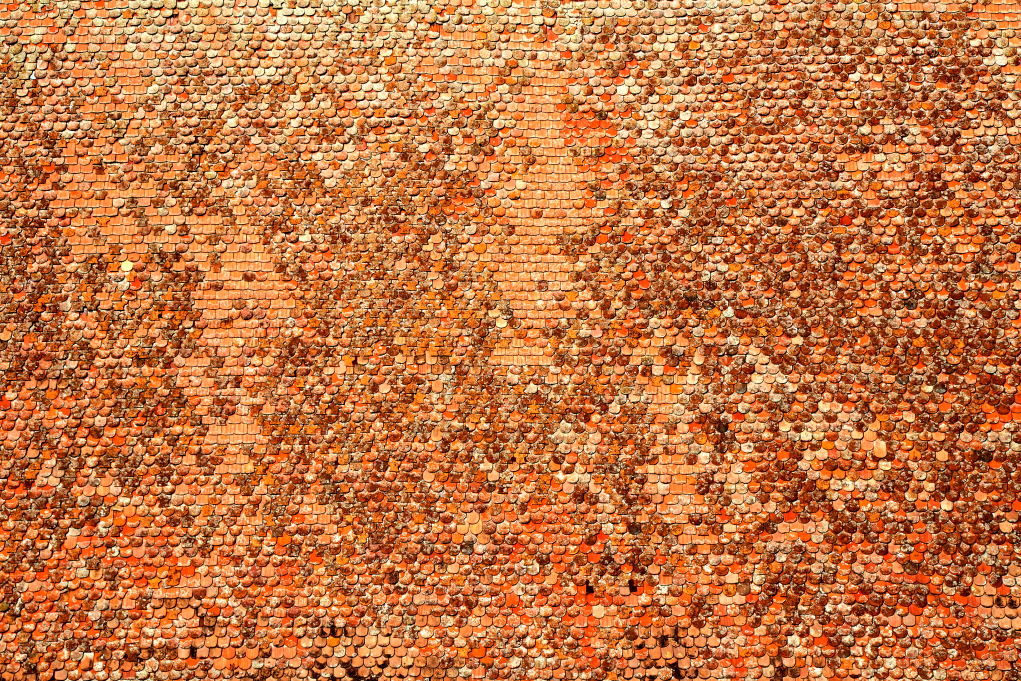

In [3]:
ImagePlus imp = IJ.openImage("https://pixy.org/src2/680/6804381.jpg");
var ip = imp.getProcessor();
ip.setMinAndMax(64, 255 - 64);
//ip.getBufferedImage();
var ipScaled = Scale.create(ip).scale(0.4);
Scale.create(ipScaled).scale(0.5).getBufferedImage();

Now we transform this with a perspective transformation:

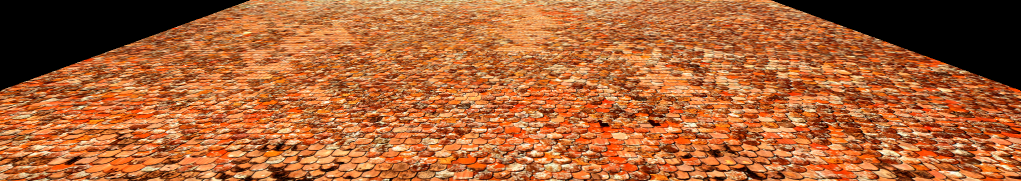

In [4]:
double w = ipScaled.getWidth();
double h = ipScaled.getHeight();
double d = 500;

var homography = new HomographyModel2D();
homography.fit(
    new double[][]{
        {d, w - d, -d, w + d},
        {0, 0, h - 2 * d, h - 2 * d}},
    new double[][]{
        {0, w, 0, w},
        {0, 0, h, h}},
    new double[]{1, 1, 1, 1});
var mapping = new PrettyMapping(ipScaled, homography);
var ip2 = ip.createProcessor((int)w, (int)h - 2 * (int)d);
mapping.map(ip2);
Scale.create(ip2).scale(0.5).getBufferedImage();

Now let's see how it looks with interpolation only, i.e. if the kernel does not integrate over transformed pixels that are larger than one source pixel:

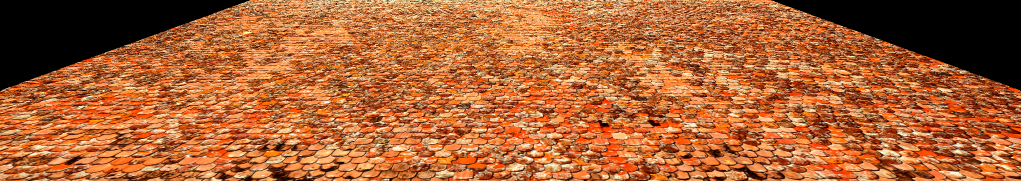

In [5]:
var mapping2 = new TransformMapping(homography);
var ip3 = ip.createProcessor((int)w, (int)h - 2 * (int)d);
mapping2.mapInverseInterpolated(ipScaled, ip3);
Scale.create(ip3).scale(0.5).getBufferedImage();

Now let's do an experiment with a proper camera model.  We can use the `RectlinearCamera` from Fiji's panorama viewer, but to use this with `PrettyMapping` we have to run it through a facade that applies the inverse of the transformation instead of the forward:

In [6]:
public class InverseOf implements CoordinateTransform {
    
    protected InverseCoordinateTransform t;
    
    public InverseOf(final InverseCoordinateTransform t) {
        
        this.t = t;
    }
    
    public void applyInPlace(final double[] point) {
        
        try { t.applyInverseInPlace(point); }
        catch (final NoninvertibleModelException e ) {
            display(e);
        }
    }
    
    public double[] apply(final double[] point) {
        
        final double[] copy = point.clone();
        applyInPlace(copy);
        return copy;
    }
}

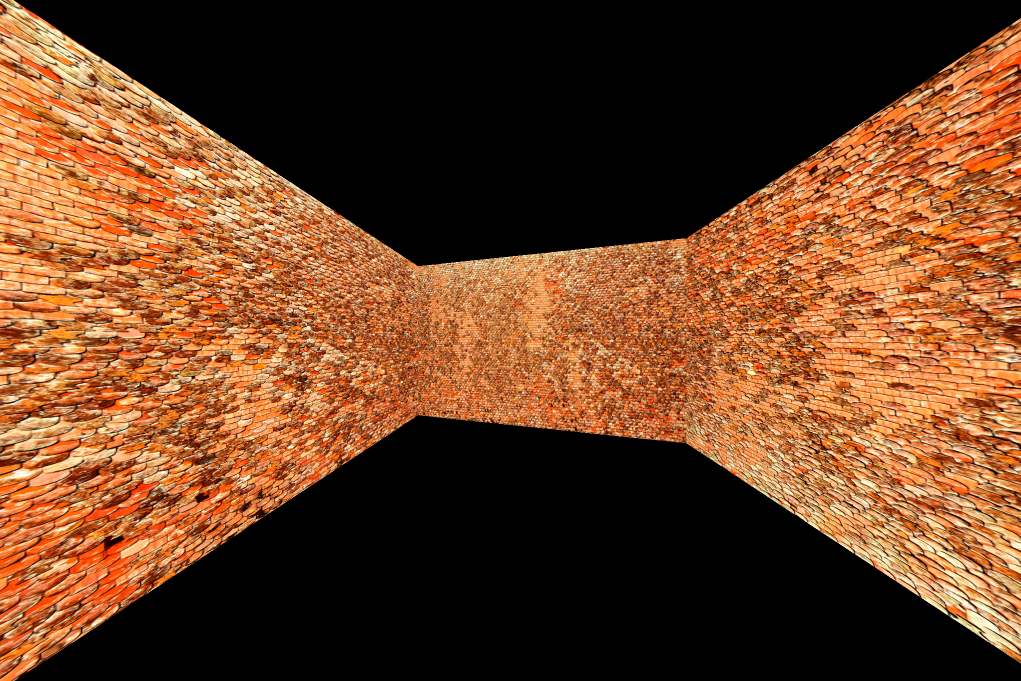

In [7]:
double w = ipScaled.getWidth();
double h = ipScaled.getHeight();
double d = 1000;

var camera = new RectlinearCamera();
camera.setSourceWidth(w - 1);
camera.setSourceHeight(h - 1);
camera.setTargetWidth(w);
camera.setTargetHeight(h);
camera.setF(0.125);
camera.pan(Math.PI * 0.05);

var mapping = new PrettyMapping(ipScaled, new InverseOf(camera));
var ip2 = ip.createProcessor((int)camera.getTargetWidth(), (int)camera.getTargetHeight());
mapping.map(ip2);

camera.pan(-Math.PI / 2);
mapping.map(ip2);

Scale.create(ip2).scale(0.5).getBufferedImage();